In [1]:

import numpy as np
import tensorflow as tf
import argparse
import os
import sys
from sklearn.metrics import f1_score
import scipy
import matplotlib.pyplot as plt
tf.set_random_seed(1234)
%pylab inline
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops


Populating the interactive namespace from numpy and matplotlib


In [2]:
input_data=tf.placeholder(dtype=tf.float32,shape=(None,28,28,1))
input_label=tf.placeholder(dtype=tf.int32,shape=(None))
training=tf.placeholder(dtype=tf.bool)
lr=tf.placeholder(dtype=tf.float32)



In [3]:
def readFile(fileName,test=False):
    data = np.loadtxt(fileName, delimiter=',')
    if test == True:
        X = np.asarray(data[:,1:],dtype=np.float32)
    else:
        X = np.asarray(data[:,1:-1],dtype=np.float32)

    if test == True:
        return X
    Y = np.asarray(data[:,-1],dtype=np.int32)
    return X,Y

trainX,trainY = readFile('./data/val.csv')

mean = np.mean(trainX,axis=0)
std = np.std(trainX, axis=0)

trainX = (trainX - mean)/std
trainX = np.reshape(newshape=(len(trainX),28,28,1),a=trainX)


In [4]:
#def make_model(input_layer,initializer):
input_layer=input_data#tf.Variable(initial_value=np.reshape(a=trainX[0],newshape=(1,28,28,1)),name='X',trainable=False)
initializer='xa'
if initializer=='he':
    initializer=tf.keras.initializers.he_normal()
else:
    initializer=None

conv1=tf.layers.conv2d(inputs=input_layer,padding='same',activation=tf.nn.relu,kernel_size=(3,3),filters=64,
kernel_initializer=initializer)

pool1=tf.layers.max_pooling2d(inputs=conv1,pool_size=(2,2),strides=(2,2))
dropout1=tf.layers.dropout(pool1,training=training,rate=0.4)

conv2=tf.layers.conv2d(inputs=dropout1,padding='same',activation=tf.nn.relu,kernel_size=(3,3),filters=128,
kernel_initializer=initializer)
pool2=tf.layers.max_pooling2d(inputs=conv2,pool_size=(2,2),strides=(2,2))
dropout2=tf.layers.dropout(pool2,training=training,rate=0.4)


conv3=tf.layers.conv2d(inputs=dropout2,padding='same',activation=tf.nn.relu,kernel_size=(3,3),filters=256,
kernel_initializer=initializer)
conv4=tf.layers.conv2d(inputs=conv3,padding='same',activation=tf.nn.relu,kernel_size=(3,3),filters=256,
kernel_initializer=initializer)
pool3=tf.layers.max_pooling2d(inputs=conv4,pool_size=(2,2),strides=(2,2))
dropout3=tf.layers.dropout(pool3,training=training,rate=0.4)
print pool3
toDense=tf.contrib.layers.flatten(inputs=dropout3)

dense1=tf.layers.dense(activation=tf.nn.relu,inputs=toDense,units=1024,
kernel_initializer=initializer)
dropout4=tf.layers.dropout(dense1,training=training,rate=0.4)


dense2=tf.layers.dense(activation=tf.nn.relu,inputs=dropout4,units=1024,
kernel_initializer=initializer)
dropout5=tf.layers.dropout(dense2,training=training,rate=0.4)

batch_normed=tf.nn.batch_normalization(dropout5,mean=0,variance=1,offset=None,scale=None,variance_epsilon=0.001)

output = tf.layers.dense(inputs=batch_normed, units=10,kernel_initializer=initializer)
#print conv1,conv2
model=output


Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 3, 3, 256), dtype=float32)


In [5]:

los=tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(
    labels=tf.to_int32(input_label), logits=model))
predicts=tf.argmax(input=model,axis=1)
optimizer=tf.train.AdamOptimizer().minimize(los)


In [6]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()



In [7]:
#load a trained saved model
saver.restore(sess, "./model3/models/model18.ckpt")
          

INFO:tensorflow:Restoring parameters from ./model3/models/model18.ckpt


Experiments to visualize filter

In [8]:
model_kernal= tf.get_default_graph().get_tensor_by_name('conv2d/kernel:0').eval()

In [9]:
kernals=np.empty((64,3,3))


In [10]:
for i in range(3):
    for j in range(3):
        for k in range(64):
            kernals[k,i,j]=model_kernal[i,j,0,k]

for i in range(64):
    scipy.misc.imsave('./kernalImages/kernal'+str(i)+'.png',kernals[i])

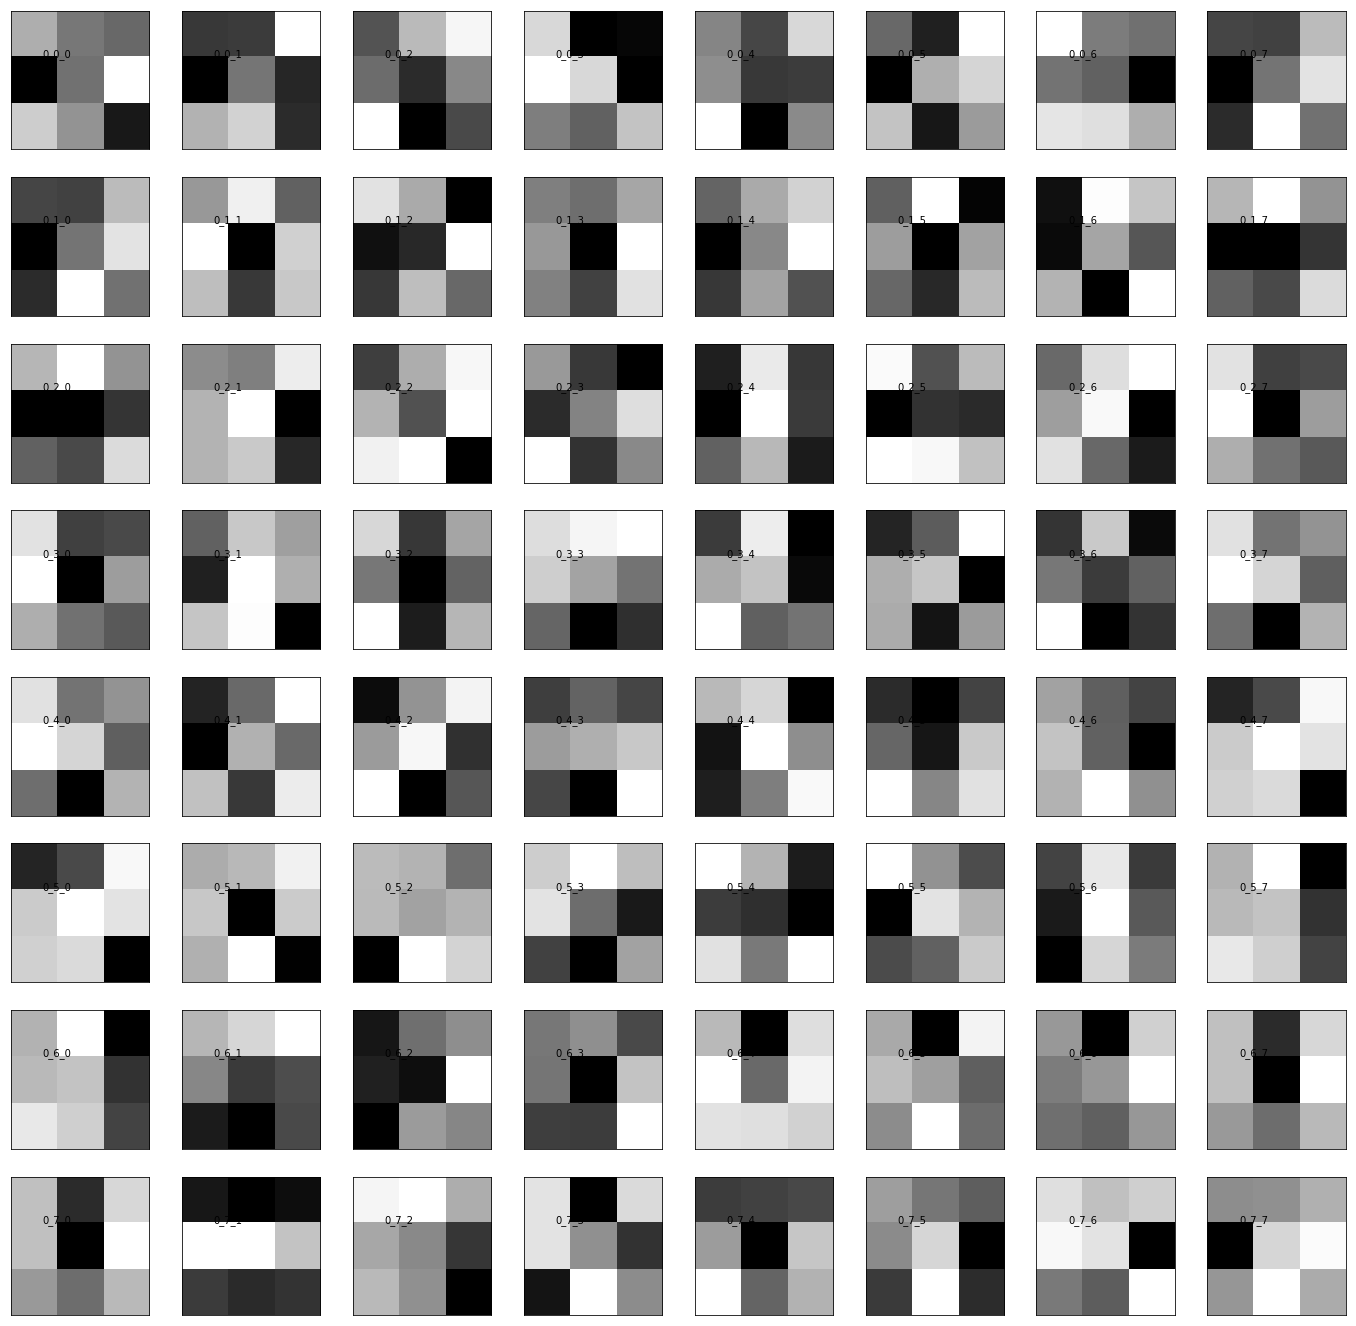

In [14]:
from matplotlib import pyplot
from matplotlib import gridspec

fig = pyplot.figure(figsize=(24, 24))

gs0 = gridspec.GridSpec(1, 1)
gs00 = gridspec.GridSpecFromSubplotSpec(8, 8, subplot_spec=gs0[0])

for i in range(8):
    for j in range(8):
        ax00 = fig.add_subplot(gs00[i, j])
        ax00.text(0.5, 0.5, '0_{}_{}'.format(i, j), ha='center')
        ax00.set_xticks([])
        ax00.set_yticks([])
        ax00.imshow(kernals[i*7+j],cmap='gray')
#the below images were rescaled to larger size for viewing in the report

Guided BackProp
https://stackoverflow.com/questions/38340791/guided-back-propagation-in-tensorflow?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

In [15]:
sample=trainX[0]
ip=tf.Variable(initial_value=np.reshape(a=sample,newshape=(1,28,28,1)),trainable=True)
data,variables=ip,tf.global_variables()


In [16]:
@ops.RegisterGradient("GuidedRelu2") 
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

In [17]:
g = tf.get_default_graph()
with g.gradient_override_map({'Relu': 'GuidedRelu2'}):
    conv1 = tf.nn.conv2d(data,variables[0],strides=[1,1,1,1],
                        padding='SAME',name='conv1')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, variables[1]),name='relu1')

    pool1 = tf.nn.max_pool(relu1,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME',name='pool1')
    dropout1=tf.layers.dropout(inputs=pool1,rate=0.4,training=False)



    conv2 = tf.nn.conv2d(dropout1,variables[2],strides=[1,1,1,1],
                        padding='SAME',name='conv2')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, variables[3]),name='relu2')

    pool2 = tf.nn.max_pool(relu2,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME',name='pool2')
    dropout2=tf.layers.dropout(inputs=pool2,rate=0.4,training=False)


    conv3 = tf.nn.conv2d(dropout2,variables[4],strides=[1,1,1,1],
                        padding='SAME',name='conv3')
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, variables[5]),name='relu3')


    conv4 = tf.nn.conv2d(relu3,variables[6],strides=[1,1,1,1],
                        padding='SAME',name='conv4')
    relu4 = tf.nn.relu(tf.nn.bias_add(conv4, variables[7]),name='relu4')





In [18]:
tf.global_variables_initializer().run()



In [19]:
mask=np.zeros((1,7,7,256))
mask[0,np.random.randint(0,6),np.random.randint(0,6),np.random.randint(0,255)]=1
allX=np.empty((20,28,28))

In [20]:
for i in range(20):
    reduced=tf.multiply(conv4,mask)
    grad=tf.gradients(reduced,ip)
    feed_dict={ip:np.reshape(a=trainX[i],newshape=(1,28,28,1))}
    influence=sess.run(grad,feed_dict=feed_dict) #influence
    allX[i]=np.reshape(a=influence,newshape=(28,28))
    

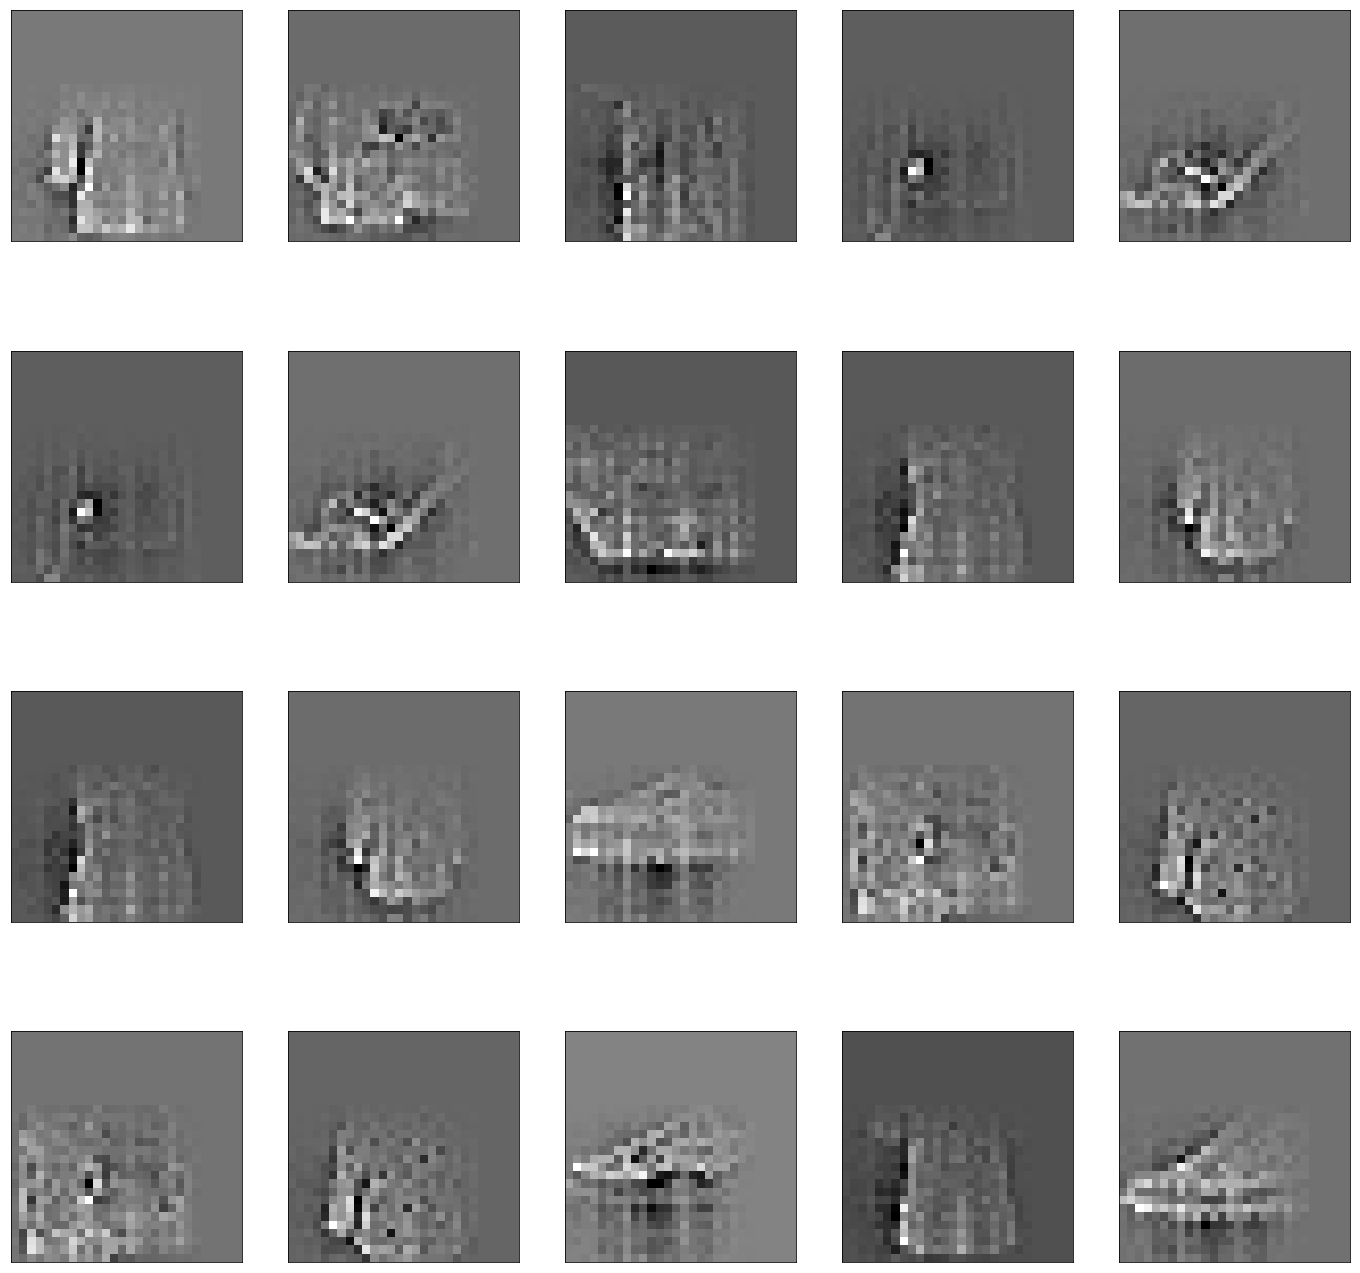

In [21]:
from matplotlib import pyplot
from matplotlib import gridspec

fig = pyplot.figure(figsize=(24, 24))

gs0 = gridspec.GridSpec(1, 1)
gs00 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[0])

for i in range(4):
    for j in range(5):
        ax00 = fig.add_subplot(gs00[i, j])
        ax00.set_xticks([])
        ax00.set_yticks([])
        ax00.imshow(allX[i*3+j],cmap='gray')
        

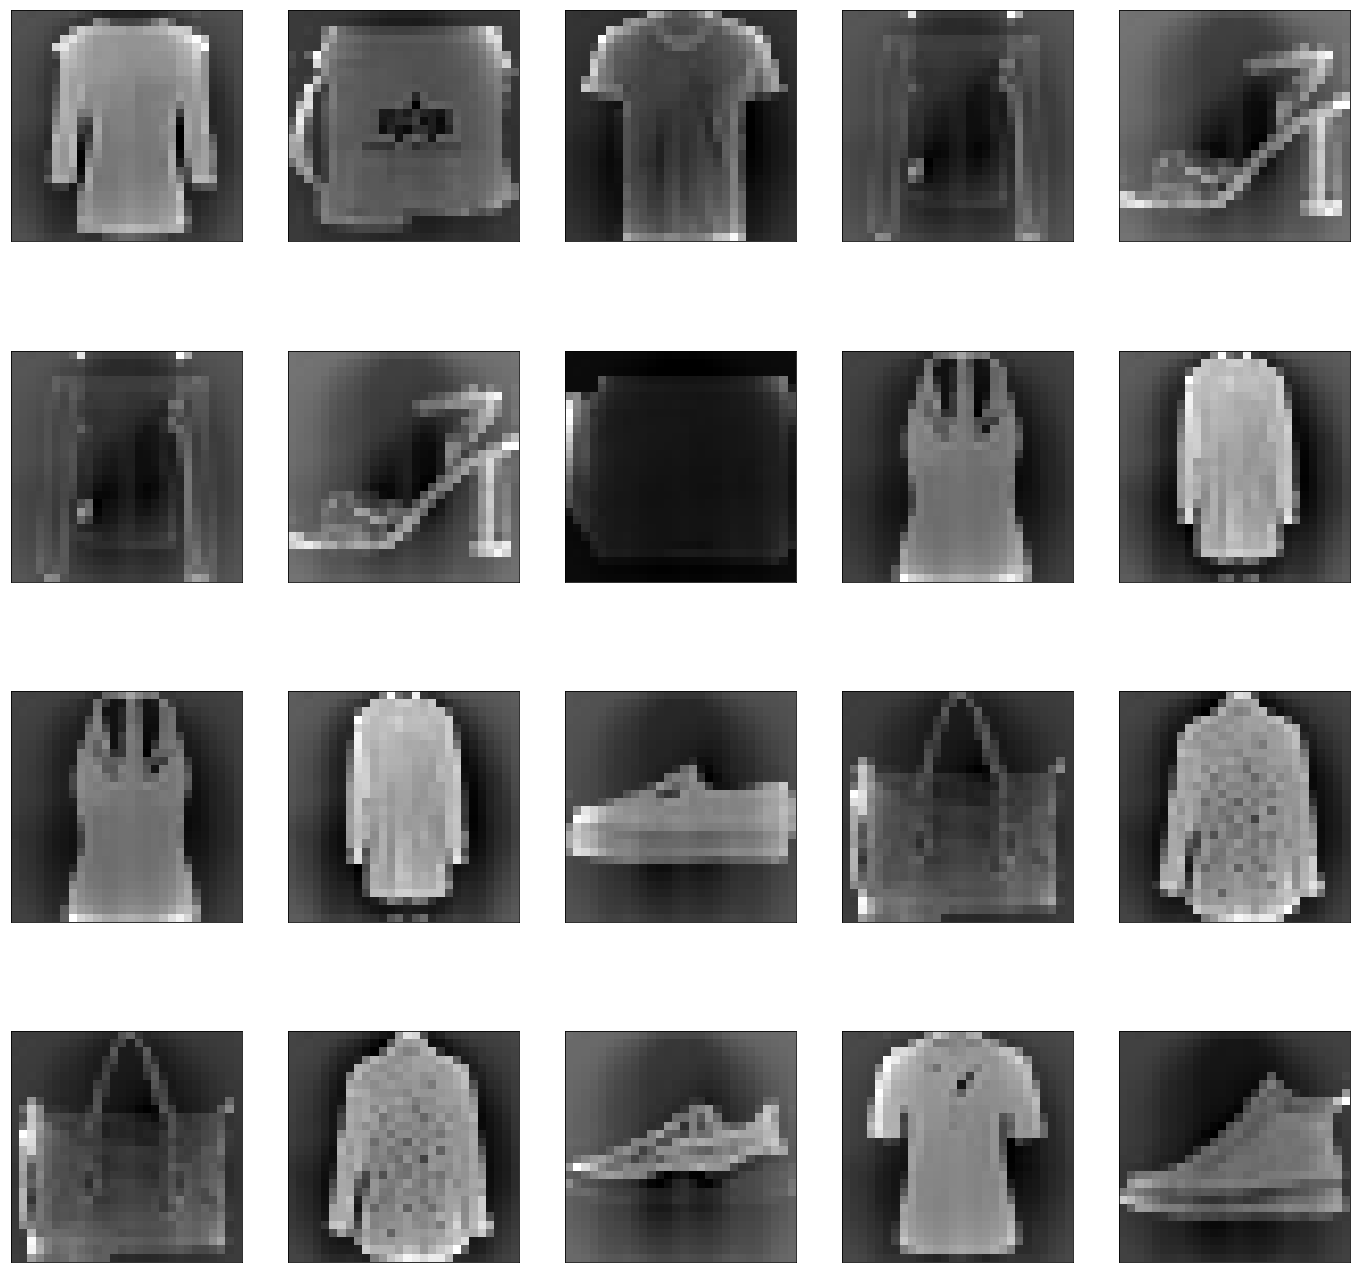

In [22]:
from matplotlib import pyplot
from matplotlib import gridspec

fig = pyplot.figure(figsize=(24, 24))

gs0 = gridspec.GridSpec(1, 1)
gs00 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[0])

for i in range(4):
    for j in range(5):
        ax00 = fig.add_subplot(gs00[i, j])
        #ax00.text(0.5, 0.5, '0_{}_{}'.format(i, j), ha='center')
        ax00.set_xticks([])
        ax00.set_yticks([])
        ax00.imshow(np.reshape(a=trainX[i*3+j],newshape=(28,28)),cmap='gray')
#these are the actual images        

Fooling the network

In [8]:
#fooling 
grad=tf.gradients(los,input_layer)
sample=np.reshape(a=trainX[0],newshape=(1,28,28,1)) #actual label is 0
print sess.run(predicts,feed_dict={input_data:sample,training:False})[0]

0


In [ ]:
mods=np.zeros((10,10,28,28))
for im in [0,22,26,15,7,4,10,8,1,25]: #hand picked that were classified correcly by network
    cl=0 # initial actual class
    sample=np.reshape(a=trainX[im],newshape=(1,28,28,1))
    cl=sess.run(predicts,feed_dict={input_data:sample,training:False})[0]
    imo=cl #tru clas label
    for cp in range(10):#[x for x in xrange(10) if x != cl]:
        #cp=7 #needed class
        sample=np.reshape(a=trainX[im],newshape=(1,28,28,1)) #actual label is 0

        count = 0
        while cl!=cp and count<10000:
            cl=sess.run(predicts,feed_dict={input_data:sample,training:False})[0]
            change=sess.run(grad,feed_dict={input_data:sample,input_label:[cp],training:False})[0]
            
            sample=sample-0.1*change
            count +=1

        if cl==cp:
            print imo,cl,
            mods[imo,cp]=np.reshape(a=sample,newshape=(28,28))
            #print sess.run(tf.nn.softmax(model),feed_dict={input_data:sample,training:False})

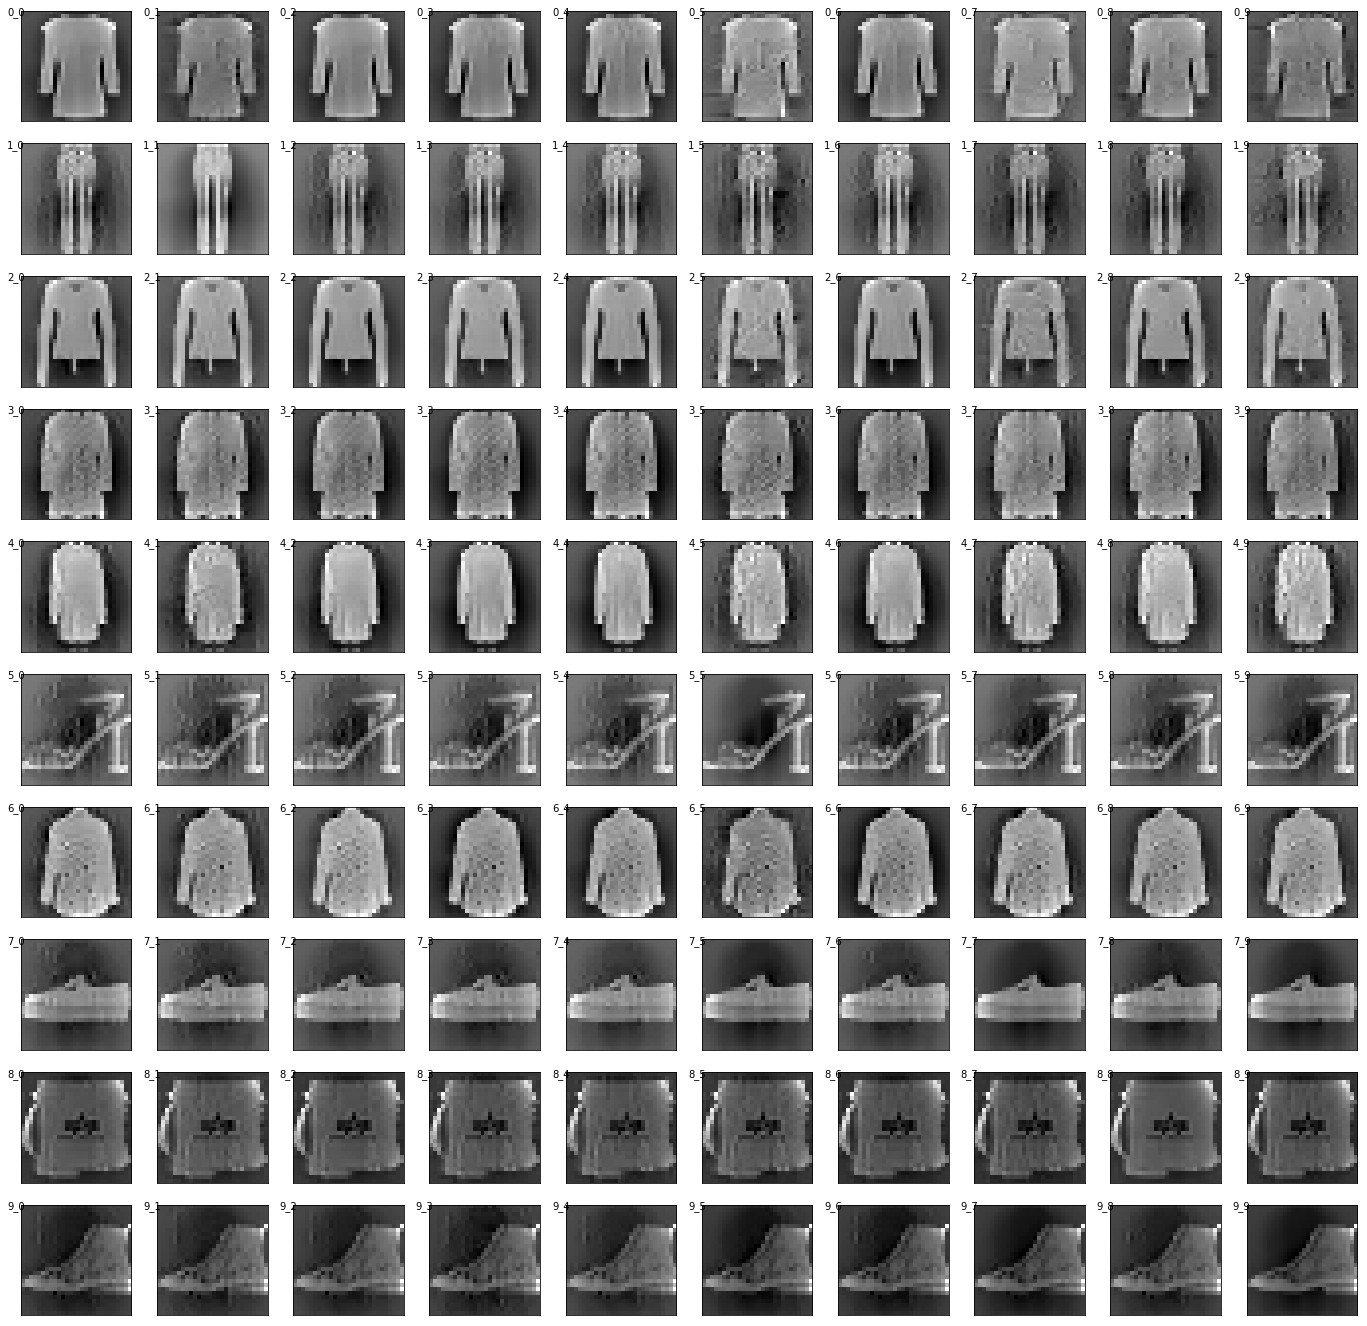

In [17]:
from matplotlib import pyplot
from matplotlib import gridspec

fig = pyplot.figure(figsize=(24, 24))

gs0 = gridspec.GridSpec(1, 1)
gs00 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gs0[0])

for i in range(10):
    for j in range(10):
        ax00 = fig.add_subplot(gs00[i, j])
        ax00.text(0.5, 0.5, '{}_{}'.format(i, j), ha='right')
        ax00.set_xticks([])
        ax00.set_yticks([])
        ax00.imshow(mods[i,j],cmap=plt.get_cmap('gray'))
        